In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import pickle

import trip
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
 np.random.seed(1)

# Data

In [3]:
# connect to database
conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

## import dataset

In [4]:
request = "SELECT trip, datetime, lon, lat, pressure, gaps, step_speed FROM dive \
            INNER JOIN trip ON dive.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE bird.species = 'SV' \
            ORDER BY trip, datetime"

data = pd.read_sql_query(request, conn)

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data

,trip,datetime,lon,lat,pressure,gaps,step_speed
0,G1107_12_SV_T1,2007-11-19 13:42:18,-78.958173,-8.566655,-0.69,FALSE,NaN
1,G1107_12_SV_T1,2007-11-19 13:42:19,-78.958148,-8.566714,-0.66,FALSE,7.120624
2,G1107_12_SV_T1,2007-11-19 13:42:20,-78.958134,-8.566773,-0.66,FALSE,6.745794
3,G1107_12_SV_T1,2007-11-19 13:42:21,-78.958121,-8.566839,-0.66,FALSE,7.484667
4,G1107_12_SV_T1,2007-11-19 13:42:22,-78.958112,-8.566910,-0.66,FALSE,7.965019
...,...,...,...,...,...,...,...
1293861,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264840,-11.773600,-0.94,FALSE,7.987543
1293862,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264860,-11.773660,-0.94,FALSE,7.987542
1293863,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773700,-0.94,FALSE,6.162400
1293864,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264930,-11.773740,-0.94,FALSE,5.072946


In [6]:
check = pd.read_csv("/home/amdroy/MEGA/DATA/FORMAT/dive_check.csv", sep = ';')
check = check[check.trip.isin(data.trip)]
check

,trip,res_sampling_gps,res_sampling_tdr,nb_sampling_gps,nb_sampling_tdr,total_duration,error_sampling_tdr,error_sampling_gps,gap_sampling_tdr,gap_sampling_gps,dupl_sampling_tdr,dupl_sampling_gps,nb_fastlog_event,dist_start_end,total_distance,max_speed,nb_dive,longest_gap,stop
0,G1107_12_SV_T1,1.0,1.0,13848,14164,3.934167,0,33,0,33,0,0,3,0.876253,150.162793,40.982442,73,62,4
1,G1107_15_SV_T1,1.0,1.0,5203,5256,1.459722,0,6,0,6,0,0,19,0.016443,68.612375,21.654447,29,32,1
2,G1107_17_SV_T1,1.0,1.0,8399,8451,2.347222,0,13,0,13,0,0,8,0.378974,83.057953,21.960488,32,11,15
3,G1107_18_SV_T1,1.0,1.0,8222,8431,2.341667,0,12,0,12,0,0,23,1.002298,89.023571,22.613399,57,68,13
4,G1107_18_SV_T2,1.0,1.0,5848,5938,1.649167,0,5,0,5,0,0,9,0.008415,82.533595,29.796162,25,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,P1113_41_SV_T4,1.0,1.0,3522,3715,1.031667,0,332,0,183,0,149,38,0.018490,45.858907,49.541660,101,10,3
409,P1113_41_SV_T5,1.0,1.0,2794,2909,0.807778,0,230,0,123,0,107,21,0.029730,35.539104,45.357780,61,11,6
410,P1113_41_SV_T6,1.0,1.0,6205,6421,1.783333,0,509,0,274,0,235,52,0.081199,82.387258,48.335260,116,10,211
417,P1113_50_SV_T1,1.0,1.0,9503,9747,2.707222,0,439,0,236,0,203,35,0.045802,62.168123,44.655350,81,63,4826


In [7]:
list_ok = check.trip[(check.longest_gap < 10) & (check.max_speed < 50) & 
                     (check.nb_dive > 0) & (check.nb_dive < 100) &
                     (check.res_sampling_gps == 1) & (check.stop < 600)]
data = data[data.trip.isin(list_ok)]
data

,trip,datetime,lon,lat,pressure,gaps,step_speed
359355,P1108_46_SV_T1,2008-12-05 15:12:39,-77.262468,-11.772947,-0.22,FALSE,NaN
359356,P1108_46_SV_T1,2008-12-05 15:12:40,-77.262453,-11.773008,-0.26,FALSE,6.984024
359357,P1108_46_SV_T1,2008-12-05 15:12:41,-77.262442,-11.773072,-0.26,FALSE,7.224129
359358,P1108_46_SV_T1,2008-12-05 15:12:42,-77.262447,-11.773147,-0.26,FALSE,8.366185
359359,P1108_46_SV_T1,2008-12-05 15:12:43,-77.262482,-11.773217,-0.22,FALSE,8.675223
...,...,...,...,...,...,...,...
1171526,P1113_41_SV_T1,2013-11-22 10:45:22,-77.264750,-11.772690,-0.44,FALSE,8.971909
1171527,P1113_41_SV_T1,2013-11-22 10:45:23,-77.264720,-11.772790,-0.44,FALSE,10.919950
1171528,P1113_41_SV_T1,2013-11-22 10:45:24,-77.264700,-11.772880,-0.51,TRUE,10.919950
1171529,P1113_41_SV_T1,2013-11-22 10:45:25,-77.264670,-11.772980,-0.51,FALSE,10.919950


In [8]:
len(data.trip.unique())

74

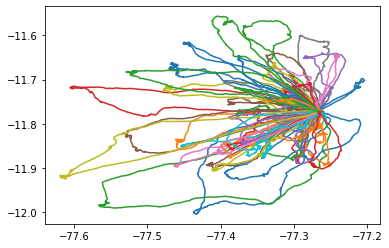

In [9]:
for i in data.trip.unique():
    trip = data[data.trip == i]
    
    plt.plot(np.array(trip.lon), np.array(trip.lat))

## split  dataset

In [10]:
idx = np.random.randint(0, len(data.trip.unique()), 20)

test_trajs = data.trip.unique()[idx]
train_trajs = np.delete(data.trip.unique(), idx)

In [11]:
data_train = data[data.trip.isin(train_trajs)]
data_test = data[data.trip.isin(test_trajs)]

In [12]:
data_train.to_csv('./hmm/data_train.csv')
data_test.to_csv('./hmm/data_test.csv')

## create dataloader

In [13]:
def dist_ortho(lon1, lat1, lon2, lat2):
    R = 6377726
    pi = np.pi
    a = np.sin((lat1 - lat2)/2*pi/180)**2
    b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
    c = np.sin((lon1- lon2)/2* pi/180)**2

    dist = R * 2* np.arcsin( np.sqrt(a + b*c))
    return dist

In [14]:
class TrajDataSet(Dataset):
    def __init__(self,  df, epoch, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.epoch = epoch
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.epoch] for i in range(len(self.df)-self.epoch)])[0]
        self.transform = transform
        
    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):
        
        i = self.start_idx[idx]
        
        traj = self.df.loc[i:i+self.epoch-1, ('lon', 'lat')]           
        traj = np.array(traj).T
        
        
        dive = self.df.loc[i:i+self.epoch-1, 'pressure']
        dive = np.array(dive)
        
        sample = (traj, dive)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

class Threshold(object):
    """Define dives with threshold

    Args:
        threshold value 
    """

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, sample):
        traj, dive = sample

        # change resolution
        dive_new = np.where( (dive - np.median(dive)) > self.threshold, 1, 0)

        return (traj, dive_new)
    
    
class Rescale(object):
    def __init__(self, ratio, method='max'):
        self.ratio = ratio
        self.method = method

    def __call__(self, sample):
        traj, dive = sample

        # change resolution
        if self.method == 'max':
            dive_new = [np.max(dive[i:i+self.ratio+1]) for i in range(len(dive)) if i%self.ratio==0]
            
        if self.method == 'mean':
            dive_new = [np.mean(dive[i:i+self.ratio+1]) for i in range(len(dive)) if i%self.ratio==0]

        return (traj, dive_new)
    
class DistMatrix(object):
    """Convert ndarrays in sample to Tensors."""    
    def __call__(self, sample):
        traj, dive = sample
        lon = np.vstack([traj[0] for i in range(traj.shape[1])])
        lat = np.vstack([traj[1]  for i in range(traj.shape[1])])
        dd = dist_ortho(lon, lat, lon.T, lat.T)
        
        return (dd/1000, dive)
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
        
    def __call__(self, sample):
        traj, dive = sample
        traj, dive = (torch.FloatTensor(traj), torch.FloatTensor(dive))
        return (traj.unsqueeze(0), dive.unsqueeze(0))

## plot data

In [15]:
# Hyperparameters
epoch = 100

In [16]:
train_set = TrajDataSet(data_train, epoch)
d = DistMatrix()
r = Rescale(10)
t = Threshold(1)

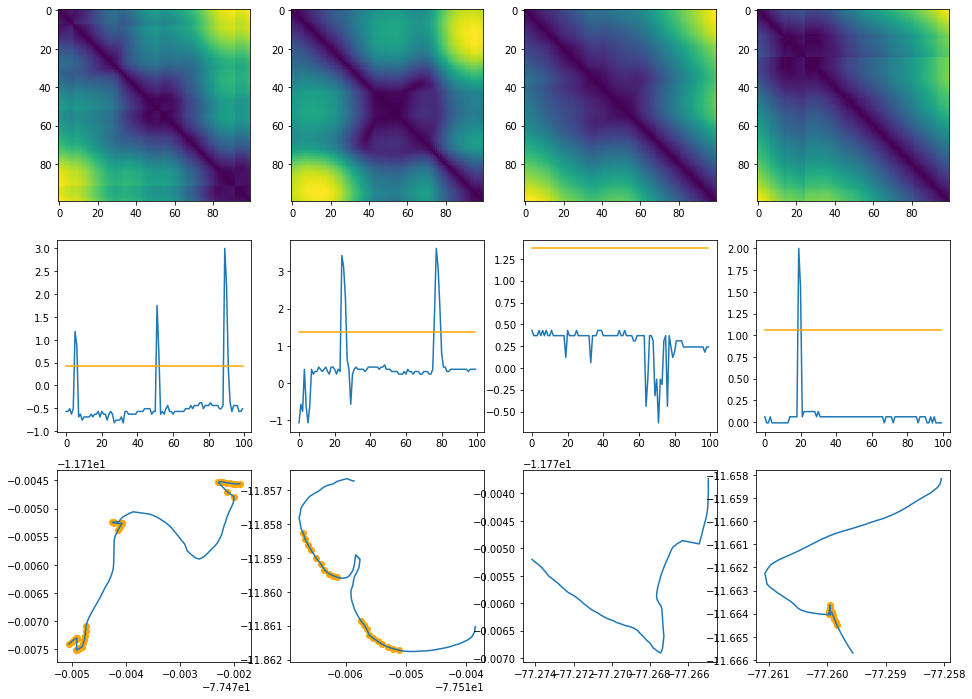

In [17]:
plt.figure(figsize=(16, 12))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, pressure = train_set[i]
    matrix_dist, dive = t(r(d(train_set[i])))
    

    plt.subplot(3,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(3,4, k+5)
    plt.plot(pressure)
    plt.plot((np.median(pressure) + 1) * np.ones(len(pressure)), c='orange')

    plt.subplot(3,4, k+9)
    dive = [dive[i] for i in range(len(dive)) for k in range(10) ]
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [18]:
batch_size = 16

train_set = TrajDataSet(data_train, epoch, transform = transforms.Compose([Threshold(1), Rescale(10), DistMatrix(), ToTensor()]))
test_set = TrajDataSet(data_test, epoch, transform = transforms.Compose([Threshold(1), Rescale(10), DistMatrix(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 2, shuffle = True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 2, shuffle = True)

In [35]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.threshold_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.threshold_2 = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.AvgPool1d(kernel_size = 10, stride = 10),
            nn.ReLU(),
            nn.Conv1d(1, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True)
            
        )
        
        self.sigmoid = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.threshold_1(x)
        out = torch.sum(out, 2)
        out = self.threshold_2(out)
        return out

In [36]:
x, y = next(iter(train_loader)) 

In [37]:
# Loss and optimizer
model = ConvNet()
out = model(x)

In [38]:
def get_score(out, y):
    out = 1*(out>0)
    true_positive = np.mean( out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (true_positive , true_negative)
#     return (true_positive.detach().numpy().item() , true_negative.detach().numpy().item())

In [39]:
# Loss and optimizer
model = ConvNet()
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([0.01]))

In [40]:
criterion(out, y)

tensor(0.4622, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [42]:
list_loss = []
list_score = []
i = 0

learning_rate = 0.1
for epoch in range(5):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for batch, (x, y) in enumerate(train_loader):
        i+=1

        # Train the model
        model.train()

    #     # send to GPU
    #     x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #     if (i + 1) % 1000 == 0:  
    #         # Test the model
    #         model.eval()
    #         with torch.no_grad():
    #             real = []
    #             estim = []

    #             for idx in test_idx:
    #                 (x,y) = test_set[idx]
    #                 x = x.unsqueeze(0)
    #                 loss = score(out, y)
    #                 real.append( y.squeeze().detach().numpy() )
    #                 estim.append( out.squeeze().detach().numpy() )

    #             real = np.hstack(real)
    #             estim = np.hstack(estim)

    #             # no dive prediction performance
    #             no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
    #             true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

    #             # dive prediction performance
    #             dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
    #             true_dive = np.sum(dive_prediction)/len(dive_prediction)

    #             score = (true_no_dive + true_dive)/2



        if (i + 1) % 1000 == 0:

            score = get_score(out,y)
            list_loss.append(loss.item())
            list_score.append(score)

            print('Epoch {}, Step {}, Loss: {}, Score: {} %'
                    .format(epoch, i + 1, loss.item(), score))

Epoch 0, Step 1000, Loss: 0.019200870767235756, Score: (0.0, 1.0) %
Epoch 0, Step 2000, Loss: 0.0064753638580441475, Score: (0.0, 1.0) %
Epoch 0, Step 3000, Loss: 0.005858143325895071, Score: (0.0, 1.0) %
Epoch 0, Step 4000, Loss: 0.004319760017096996, Score: (0.0, 1.0) %
Epoch 0, Step 5000, Loss: 0.005270694382488728, Score: (0.0, 1.0) %
Epoch 0, Step 6000, Loss: 0.0038824386429041624, Score: (0.0, 1.0) %
Epoch 0, Step 7000, Loss: 0.002043528715148568, Score: (0.0, 1.0) %
Epoch 0, Step 8000, Loss: 0.006561107933521271, Score: (0.0, 1.0) %
Epoch 0, Step 9000, Loss: 0.007459419779479504, Score: (0.0, 1.0) %
Epoch 0, Step 10000, Loss: 0.007487715687602758, Score: (0.0, 1.0) %
Epoch 1, Step 11000, Loss: 0.004282956477254629, Score: (0.0, 1.0) %
Epoch 1, Step 12000, Loss: 0.006562800612300634, Score: (0.0, 1.0) %
Epoch 1, Step 13000, Loss: 0.004740930162370205, Score: (0.0, 1.0) %
Epoch 1, Step 14000, Loss: 0.005651349667459726, Score: (0.0, 1.0) %
Epoch 1, Step 15000, Loss: 0.003376780543

KeyboardInterrupt: 

In [43]:
out

tensor([[[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3536, -7.3536]],

        [[-7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536, -7.3536,
          -7.3536, -7.3

# First time passage

In [ ]:
def residence_time(dist_matrix, radius):
    residence_matrix = dist_matrix < radius
    residence = [sum(residence_matrix[:,i]) for i in range(dist_matrix.shape[0])]
    return np.array(residence)

def first_time_passage(dist_matrix, radius):
    first_passage = np.zeros(dist_matrix.shape[0])
    residence_matrix = dist_matrix < radius
    if np.sum(residence_matrix) > 0 :
        for i in range(dist_matrix.shape[0]):
            idx = np.where(residence_matrix[:,i])[0]
            delta = np.diff(idx)
            # get index start
            i_start = i
            while i_start in idx:
                i_start -=1
            # get index end
            i_end = i
            while i_end in idx:
                i_end +=1
            # get number of point
            first_passage[i] = i_end-i_start+1

    return first_passage

In [ ]:
radius = 250/5000
time_threshold = 60

In [ ]:
real = []
estim = []

for idx in test_idx:
    (x,y) = test_set[idx]
    x = x.squeeze().numpy()
    
    residence = residence_time(x, radius)
    out = residence > time_threshold
    
    # dive prediction
    real.append( y.squeeze().detach().numpy() )
    estim.append( 1*out )
    
real = np.hstack(real)
estim = np.hstack(estim)

# no dive prediction performance
no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

# dive prediction performance
dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
true_dive = np.sum(dive_prediction)/len(dive_prediction)

score = (true_no_dive + true_dive)/2
score

In [ ]:
true_no_dive

In [ ]:
true_dive

In [ ]:
np.sum(real == 0)/len(real)

In [ ]:
np.sum(real == estim)/len(real)